## Evaluating ConcolicGrammarFuzzer

In this chapter, we will evaluate `ConcolicGrammarFuzzer`, which is our concolic fuzzer that uses grammars.

Our target will be a basic program that mimics an SQL database. We will fuzz this program using the `INVENTORY_GRAMMAR`, both with `ConcolicGrammarFuzzer` and `GrammarCoverageFuzzer`, then we will compare the success of these fuzzers. Namely, we will consider **line coverage**, **branch coverage** and **program depth** reached.

In [1]:
import fuzzingbook_utils

In [2]:
from ConcolicFuzzer import ConcolicGrammarFuzzer, ConcolicTracer
from GrammarFuzzer import GrammarFuzzer
from GrammarCoverageFuzzer import GrammarCoverageFuzzer

## Target Program

In [3]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException
from ConcolicFuzzer import ConcolicDB
from copy import deepcopy

INITIAL_DB = [
    (
        'vehicles',
        (
            {'year': int, 'kind': str, 'company': str, 'model': str},
            [
                {'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
                {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
                {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}
            ]
        )
    ),
    (
        'months',
        (
            {'month': int, 'name': str},
            [
                {'month': 1, 'name': 'jan'},
                {'month': 2, 'name': 'feb'},
                {'month': 3, 'name': 'mar'},
                {'month': 4, 'name': 'apr'},
                {'month': 5, 'name': 'may'},
                {'month': 6, 'name': 'jun'},
                {'month': 7, 'name': 'jul'},
                {'month': 8, 'name': 'aug'},
                {'month': 9, 'name': 'sep'},
                {'month': 10, 'name': 'oct'},
                {'month': 11, 'name': 'nov'},
                {'month': 12, 'name': 'dec'}
            ]
        )
    )
]

def db_select(query):
    global INITIAL_DB
    concolic_db = ConcolicDB()
    concolic_db.db = deepcopy(INITIAL_DB)
    return concolic_db.sql(query)

## Coverage

In [25]:
import sys

class FilteredCoverage:
    def __init__(self, functions=set()):
        self._traces = []
        self._line_coverage = set()
        self._branch_coverage = set()
        self._functions = functions
    
    def __enter__(self):
        self.original_tracer = sys.gettrace()
        sys.settrace(self._tracer)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_tracer)
        
    def _tracer(self, frame, event, arg):
        if self.original_tracer is not None:
            self.original_tracer(frame, event, arg)
            
        should_trace = (event == 'line' and 
                        frame.f_code.co_name in self._functions)
        
        if should_trace:
            function_name = frame.f_code.co_name
            line_no = frame.f_lineno
            trace = (function_name, line_no)
            
            if len(self._traces) > 0:
                last_trace = self._traces[-1]
                self._branch_coverage.add((last_trace, trace))
                
            self._traces.append(trace)
            self._line_coverage.add(trace)

        return self._tracer
    
    def get_traces(self):
        return self._traces

    def get_line_coverage(self):
        return self._line_coverage
    
    def get_branch_coverage(self):
        return self._branch_coverage

In [26]:
from collections import defaultdict

class Result:
    def __init__(
            self, 
            functions,
            fuzzer_name,
            line_coverage, 
            branch_coverage, 
            exceptions, 
            elapsed_time):
        
        self.line_coverage = line_coverage
        self.branch_coverage = branch_coverage
        self.exceptions = exceptions
        
        self.functions = functions
        self.fuzzer_name = fuzzer_name
        
        self.n_lines_covered = len(line_coverage)
        self.n_branches_covered = len(branch_coverage)
        self.n_exceptions = len(exceptions)

        self.line_coverage_dict = self._generate_line_coverage_dict()
        self.branch_coverage_dict = self._generate_branch_coverage_dict()
        self.exceptions_dict = self._generate_exceptions_dict()
        
        self.elapsed_time = elapsed_time

    def _generate_line_coverage_dict(self):
        line_coverage_dict = defaultdict(list)
        for function_name, line in self.line_coverage:
            line_coverage_dict[function_name].append(line)
        return line_coverage_dict

    def _generate_branch_coverage_dict(self):
        branch_coverage_dict = defaultdict(list)
        for branch in self.branch_coverage:
            function_name = branch[0][0]
            branch_coverage_dict[function_name].append(branch)
        return branch_coverage_dict
            
    def _generate_exceptions_dict(self):
        exceptions_dict = defaultdict(list)
        for e in self.exceptions:
            e_type = type(e).__name__
            exceptions_dict[e_type].append(e)
        return exceptions_dict

In [27]:
import matplotlib.pyplot as plt
import numpy as np

class ResultComparator:
    def __init__(self, result1, result2):
        self._result1 = result1
        self._result2 = result2
        
        self._name1 = result1.fuzzer_name
        self._name2 = result2.fuzzer_name
        
        assert(result1.functions == result2.functions)
        self._functions = result1.functions

    def _print_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        print_format = '{0: <30} {1: <25} {2: <25}'
        print()
        print(print_format.format(title, self._name1, self._name2))
        print('-' * 80)
        print(print_format.format('all functions', n1, n2))
        
        for f in self._functions:
            n_lines1 = len(cov_dict1[f])
            n_lines2 = len(cov_dict2[f])
            print(print_format.format(f, n_lines1, n_lines2))
    
    def _plot_coverage_comparison(self, cov_dict1, n1, cov_dict2, n2, title):
        x_indexes = [i for i in range(len(self._functions) + 1)]
        x_labels = ['all functions'] + list(self._functions)

        plt.title(title)
        plt.bar([x-0.1 for x in x_indexes], 
                [n1] + [len(cov_dict1[f]) for f in self._functions],  
                width=0.2, align='center', label=self._name1)

        plt.bar([x+0.1 for x in x_indexes], 
                [n2] + [len(cov_dict2[f]) for f in self._functions],  
                width=0.2, align='center', label=self._name2)

        plt.legend(loc='upper right')
        plt.xticks(x_indexes, x_labels, rotation=20)
        plt.show()
        
    def compare_line_coverage(self):
        args = [
            self._result1.line_coverage_dict,
            self._result1.n_lines_covered,
            self._result2.line_coverage_dict,
            self._result2.n_lines_covered,
            'Line Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_branch_coverage(self):
        args = [
            self._result1.branch_coverage_dict,
            self._result1.n_branches_covered,
            self._result2.branch_coverage_dict,
            self._result2.n_branches_covered,
            'Branch Coverage'
        ]
        
        self._print_coverage_comparison(*args)
        self._plot_coverage_comparison(*args)
    
    def compare_exceptions(self):
        e_dict1 = self._result1.exceptions_dict
        e_dict2 = self._result2.exceptions_dict
        
        print_format = '{0: <30} {1: <25} {2: <25}'
        print()
        print(print_format.format('Exception Type', self._name1, self._name2))
        print('-' * 80)
        
        all_e_types = e_dict1.keys() | e_dict2.keys()
        for e_type in all_e_types:
            n1 = len(e_dict1[e_type])
            n2 = len(e_dict2[e_type])
            print(print_format.format(e_type, n1, n2))
    
    def compare_elapsed_time(self):
        t1 = self._result1.elapsed_time
        t2 = self._result2.elapsed_time
        
        print_format = '{0: <30} {1: <25} {2: <25}'
        print()
        print(print_format.format('Elapsed Time (s)', self._name1, self._name2))
        print('-' * 80)
        print(print_format.format('', round(t1, 2), round(t2, 2)))
        
    def compare_all(self):
        self.compare_line_coverage()
        self.compare_branch_coverage()
        self.compare_exceptions()
        self.compare_elapsed_time()

## Runners

In [28]:
import time

In [35]:
def fuzz_n_times(target, functions, fuzzer, n):
    def run_target(inp):
        if 'concolic' in fuzzer.__class__.__name__.lower():
            with ConcolicTracer() as tracer:
                try:
                    return tracer[target](inp)
                except Exception as e:
                    raise e
                finally:
                    fuzzer.update_grammar(tracer)
        else:
            return target(inp)
    
    line_coverage = set()
    branch_coverage = set()
    exceptions = []

    start_time = time.time()
    
    for _ in range(n):
        inp = fuzzer.fuzz()
        with FilteredCoverage(functions) as fc:
            try:
                run_target(inp)
            except Exception as e:
                exceptions.append(e)

        line_coverage |= fc.get_line_coverage()
        branch_coverage |= fc.get_branch_coverage()
        
    elapsed_time = time.time() - start_time
    
    return Result(functions,
                  fuzzer.__class__.__name__,
                  line_coverage, 
                  branch_coverage, 
                  exceptions, 
                  elapsed_time)

In [ ]:
def run_fuzzer_class(fuzzer_class, fuzzer_config, run_config):
    fuzzer = fuzzer_class(**fuzzer_config)  
    fuzzer_name = fuzzer.__class__.__name__
    
    if 'concolic' in fuzzer_name.lower():
        pass
    else:
        assert ('grammar' in fuzzer_name.lower())
        pass

In [42]:
def run_grammar_fuzzer(
        target, 
        grammar, 
        max_nonterminals,
        n_fuzz,
        functions): 
    
    gf = GrammarFuzzer(grammar=grammar, 
                        max_nonterminals=max_nonterminals)
    
    result = fuzz_n_times(target=target, 
                          functions=functions, 
                          fuzzer=gf, 
                          n=n_fuzz)
    
    return result

In [43]:
def run_concolic_grammar_fuzzer(
        target, 
        grammar, 
        max_nonterminals, 
        n_fuzz,
        functions):
    
    cgf = ConcolicGrammarFuzzer(grammar=grammar,
                                max_nonterminals=max_nonterminals)

    tokens_to_prune = ['<value>', '<table>', '<column>', 
                       '<literals>', '<exprs>', '<bexpr>'] 
    
    cgf.prune_tokens(tokens_to_prune)
    
    result = fuzz_n_times(target=target, 
                          functions=functions, 
                          fuzzer=cgf, 
                          n=n_fuzz)
    
    return result

## Fuzzing Configuration

In [45]:
N_FUZZ = 10
TARGET = db_select
GRAMMAR = INVENTORY_GRAMMAR
MAX_NONTERMINALS = 10
FUNCTIONS = {
    'sql', 
    'table',
    'do_update', 
    'do_insert', 
    'do_delete', 
    'db_select'
}

# Evaluation

## Comparative Run

In [53]:
def comperative_run(runner1, config1, runner2, config2):
    result1 = runner1(**config1)
    result2 = runner2(**config2)
    result_comparator = ResultComparator(result1, result2)    
    result_comparator.compare_all()
    return result1, result2


Line Coverage                  ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  56                        29                       
sql                            7                         7                        
do_update                      16                        6                        
db_select                      3                         3                        
do_delete                      11                        5                        
table                          4                         3                        
do_insert                      15                        5                        


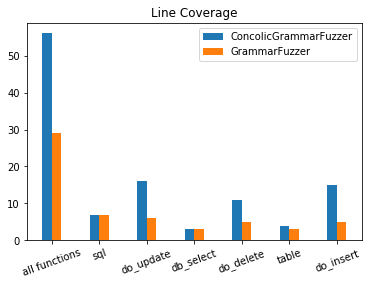


Branch Coverage                ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
all functions                  63                        33                       
sql                            11                        11                       
do_update                      16                        6                        
db_select                      3                         3                        
do_delete                      11                        5                        
table                          7                         3                        
do_insert                      15                        5                        


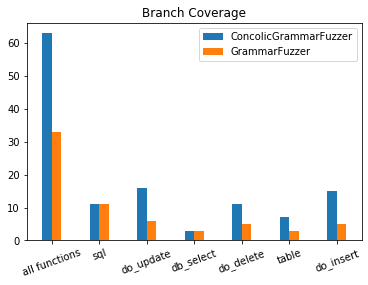


Exception Type                 ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
SQLException                   95                        100                      
TypeError                      4                         0                        

Elapsed Time (s)               ConcolicGrammarFuzzer     GrammarFuzzer            
--------------------------------------------------------------------------------
                               9.49                      2.52                     


In [55]:
config = {
    'target': TARGET, 
    'grammar': GRAMMAR, 
    'max_nonterminals': MAX_NONTERMINALS, 
    'n_fuzz': 100,
    'functions': FUNCTIONS
}

result1, result2 = comperative_run(
    runner1=run_concolic_grammar_fuzzer,
    config1=config,
    runner2=run_grammar_fuzzer,
    config2=config
)

In [82]:
def sum_results(results):
    assert (len(results) > 1)
    
    functions = sorted(results[0].functions)
    fuzzer_name = results[0].fuzzer_name
    line_coverage = {}
    branch_coverage = {}
    exceptions = []
    elapsed_time = 0
    
    assert (all(sorted(r.functions) == functions for r in results))
    assert (all(r.fuzzer_name == fuzzer_name for r in results))
    
    for result in results:
        line_coverage |= result.line_coverage
        branch_coverage |= result.branch_coverage
        exceptions += result.exceptions
        elapsed_time += result.elapsed_time
        
    return Result(functions,
                  fuzzer_name,
                  line_coverage, 
                  branch_coverage, 
                  exceptions, 
                  elapsed_time)